# Welcome to the Lightning + Grid + NGC Workshop

In this workshop you will learn how to leverage the Nvidia NGC model hub to train a Automatic Speech Recognition model using Grid.ai, PyTorch Lightning, and Nemo.  Before we get started let's familiarize ourselves with these technologies.

## What is the NVIDIA NGC Catalog?
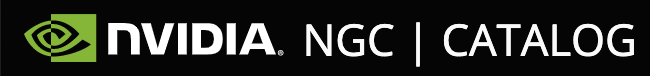

The NVIDIA NGC catalog is the hub for GPU-optimized software including AI/ML containers, pre-trained models, and SDKs that can be easily deployed across on-premises, cloud, edge, and hybrid environments. NGC offers Transfer Learning Toolkit that enables retraining models on custom data and Triton Inference Server to run predictions on CPU and GPU-powered systems. 

## What is PyTorch Lightning?
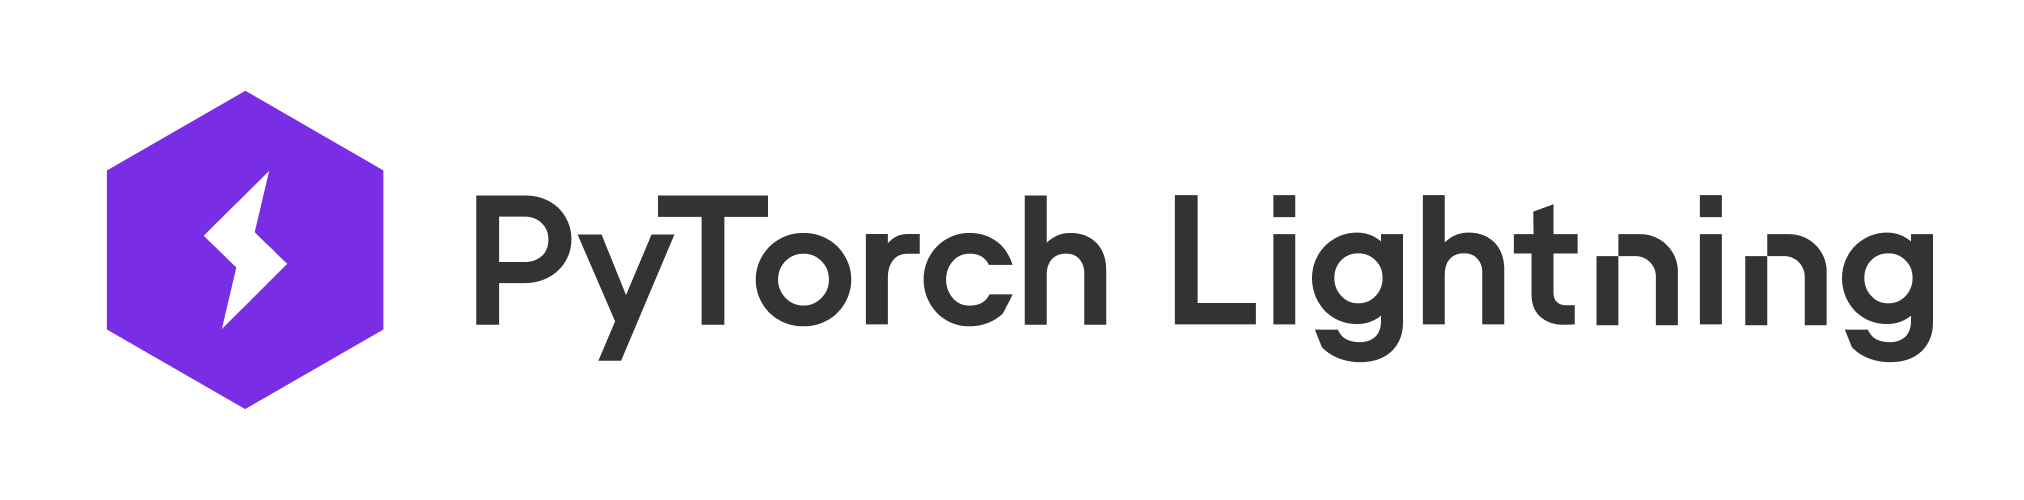

PyTorch Lightning is a light weight PyTorch wrapper that reduces the engineering boilerplate and resources required to implement state-of-the-art AI. Organizing PyTorch code with Lightning, enables seamless training on multiple-GPUs, TPUs, CPUs as well as the use of difficult to implement best practices such as model sharding, 16-bit precision and more. PyTorch Lightning support an extremly robust ecosystem of Machine Learning and Deep Learning projects from 1st Party Repos such as Flash to 3rd party frameworks such as Nvidia NeMo.

## What is NVIDIA NeMo?
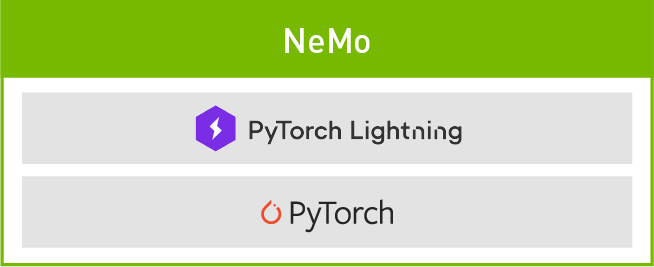

NVIDIA NeMo is a conversational AI toolkit built for researchers working on automatic speech recognition (ASR), natural language processing (NLP), and text-to-speech synthesis (TTS). The primary objective of NeMo is to help researchers from industry and academia to reuse prior work (code and pretrained models and make it easier to create new conversational AI models.

## What is Grid.ai?
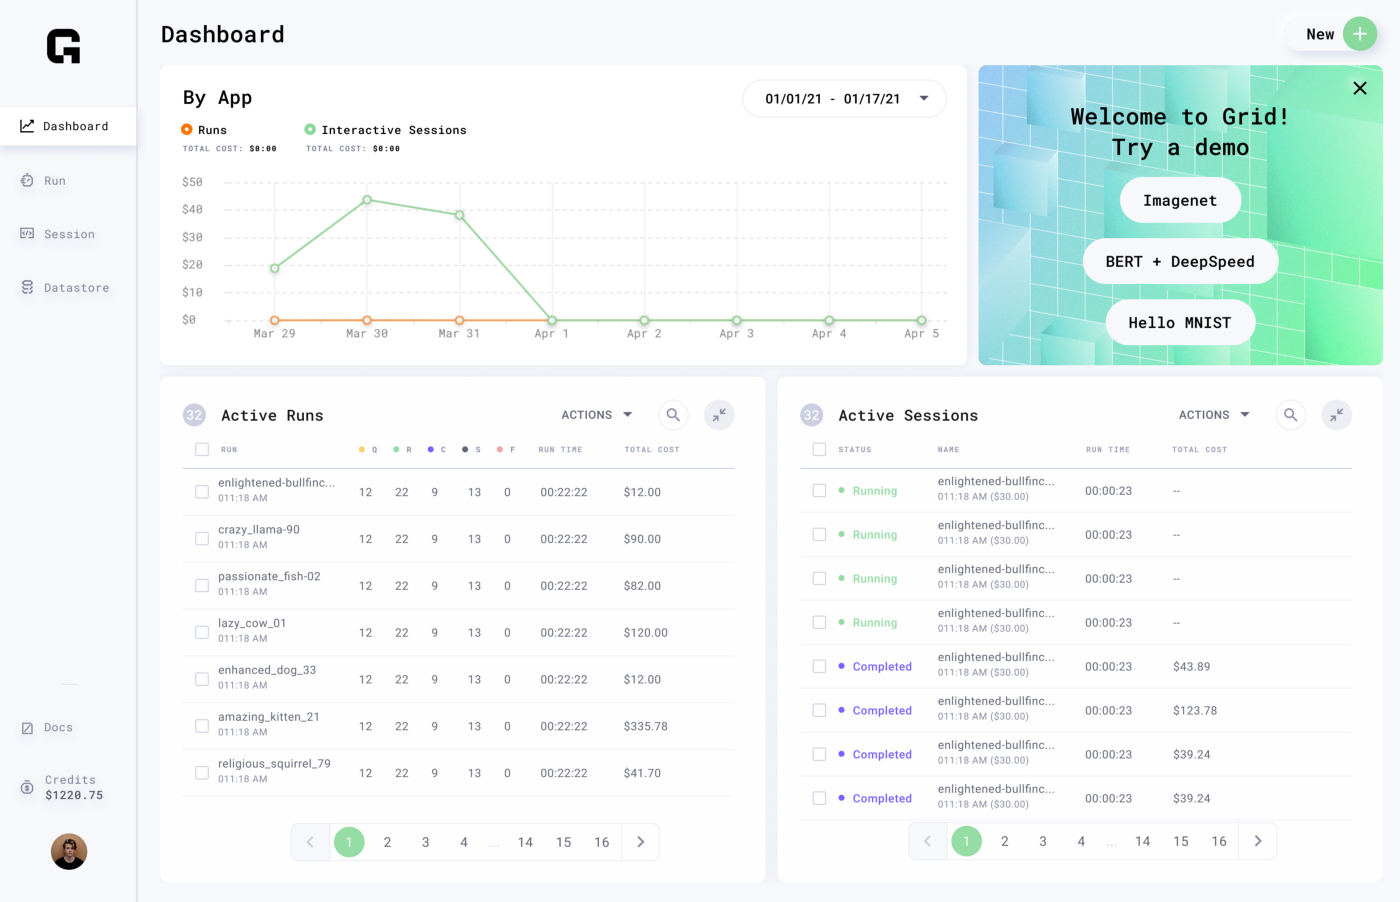

Developed by the creators of PyTorch Lightning, Grid is a machine learning platform that enables you to scale training from your laptop to the cloud without having to modify a single line of code. Just as Lightning decoupled machine learning research from engineering code, Grid aims to decouple Machine Learning from MLOps.


Grid Datastores enable your training code to access vast volumes of data from the cloud as if it was located on your laptop’s local filesystem. Grid Datastores are optimized for Machine Learning operations allowing your models to train at peak speed without taking on technical debt or needing to navigate the complexities of optimizing cloud storage for Machine Learning. Grid Datastores can be created through both the Grid command line and Web interfaces read more here.

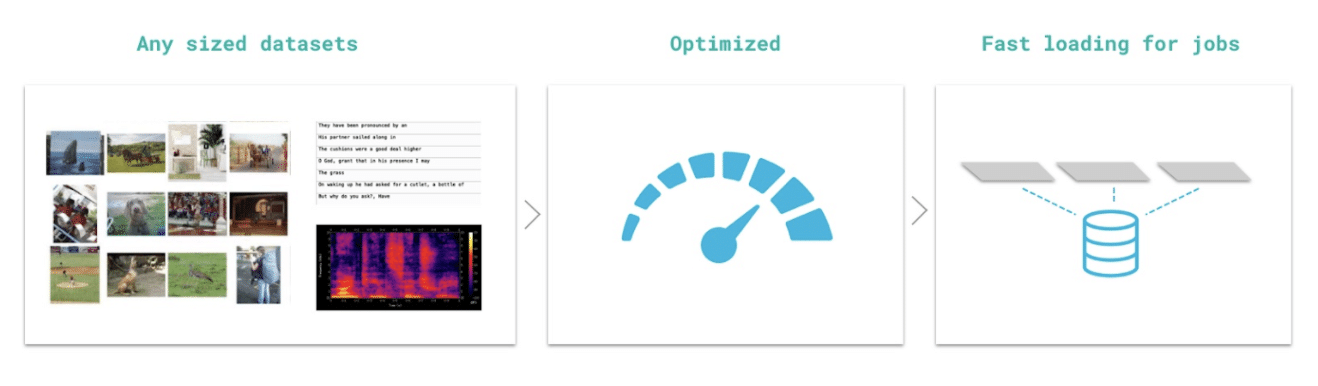


Grid Sessions run on the same hardware you need to scale while providing you with pre-configured environments to iterate the research phase of the machine learning process faster than before. Sessions are linked to Github, loaded with JupyterHub, and can be accessed through SSH and your IDE of choice without having to do any setup yourself. With sessions, you pay only for the compute you need (simply pause and resume) to get a baseline operational, and then you can scale your work to the cloud with runs.

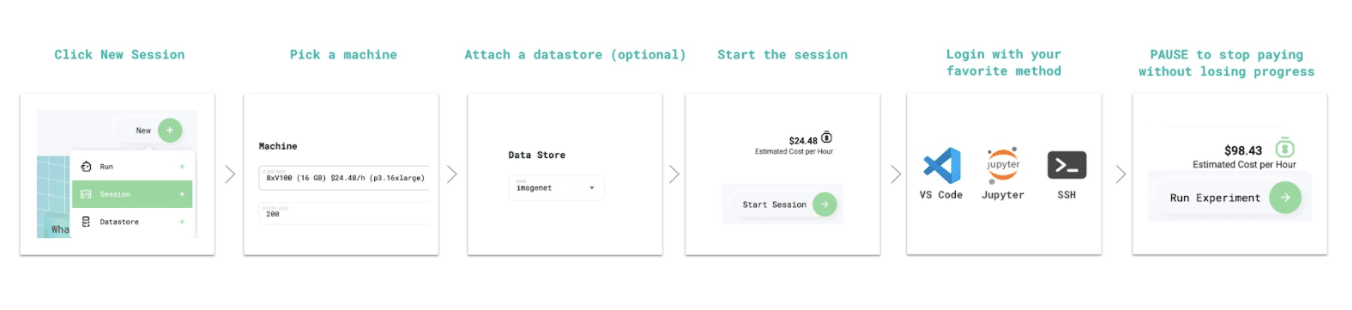

Grid Runs enable you to scale your machine learning code to hundreds of GPUs and model configurations without needing to change a single line of machine learning code. If your code runs in a session with Grid Runs it will scale to the cloud. With support for major frameworks like Tensorflow, Keras, PyTorch, PyTorch Lightning Grid Runs enable all the Production MLOps Training best practices such as full hyperparameter sweep, multi node scaling, native logging,  asset management, and interruptible pricing all out of the box you needing to modify a single line of machine learning code.

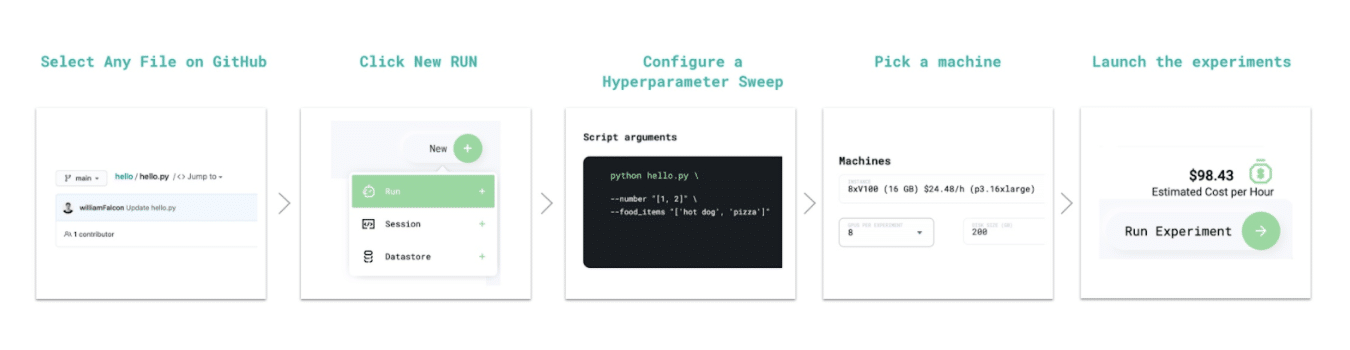


## Workshop Prerequisites
Now that we have an understanding of these technologies let's quickly install all the packages we will need for this workshop if you are running this notebook in a Grid Session everything should run out of the box.

The remainder of this workshop has been adapted from the offical [NeMo ASR tutorial](https://github.com/NVIDIA/NeMo/blob/main/tutorials/asr/01_ASR_with_NeMo.ipynb), while some content as been modified to fit the flow of this workshop much of the code and exposition has been taken verbaitm and the author is indebted to the open source efforts by the NeMo team. 



In [9]:
## Install dependencies
!pip install wget
!sudo apt-get install sox libsndfile1 ffmpeg -y
!pip install unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'main'
!python -m pip install --user git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all] 

## Grab the config we'll use in this example
!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-7).
sox is already the newest version (14.4.2+git20190427-2).
ffmpeg is already the newest version (7:4.2.4-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-oykgcwck/nemo-toolkit_487dc8deff45432985d2838ad0773b3b
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-oykgcwck/nemo-toolkit_487dc8deff45432985d2838ad0773b3b
  Resolved https://github.com/NVIDIA/NeMo.git to commit 1d262c725df150ba837146e7899d8167adf524f6
mkdir: cannot create directory ‘configs’: File exists
--2021-08-19 09:22:37--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/config.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to 


Now let's download and prepare our data we'll explore this more later in the workshop

In [1]:
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

In [2]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'http://www.speech.cs.cmu.edu/databases/an4/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Tarfile already exists.
Finished conversion.
******


# Workshop Steps

## Step 1: Introduction to End-To-End Automatic Speech Recognition

Lets explore the basics of speech recognition, then explore concrete examples of what the data looks like and walk through putting together a simple end-to-end ASR pipeline.

This workshop is based of the ASR Tutorial in the NeMo [NeMo framework](https://github.com/NVIDIA/NeMo).
We assume that you are familiar with general machine learning concepts and can follow Python code, and we'll be using the [AN4 dataset from CMU](http://www.speech.cs.cmu.edu/databases/an4/) (with processing using `sox`).

### A Brief History of Automatic Speech Recognition?

**Automatic Speech Recognition**, or ASR is the task of automatically transcribing spoken language (speech-to-text). ASR models are typically metriced by evaluating their  **Word Error Rate (WER)** which mesures how many words the model correctly transcribes on a given test dataset.

Traditional speech recognition models relied on latent generative modeling pipelines which combine traditional **language**, **acoustic**, and **pronunciation** models to generate the most likely sequence of text that would match an given input audio sample. 

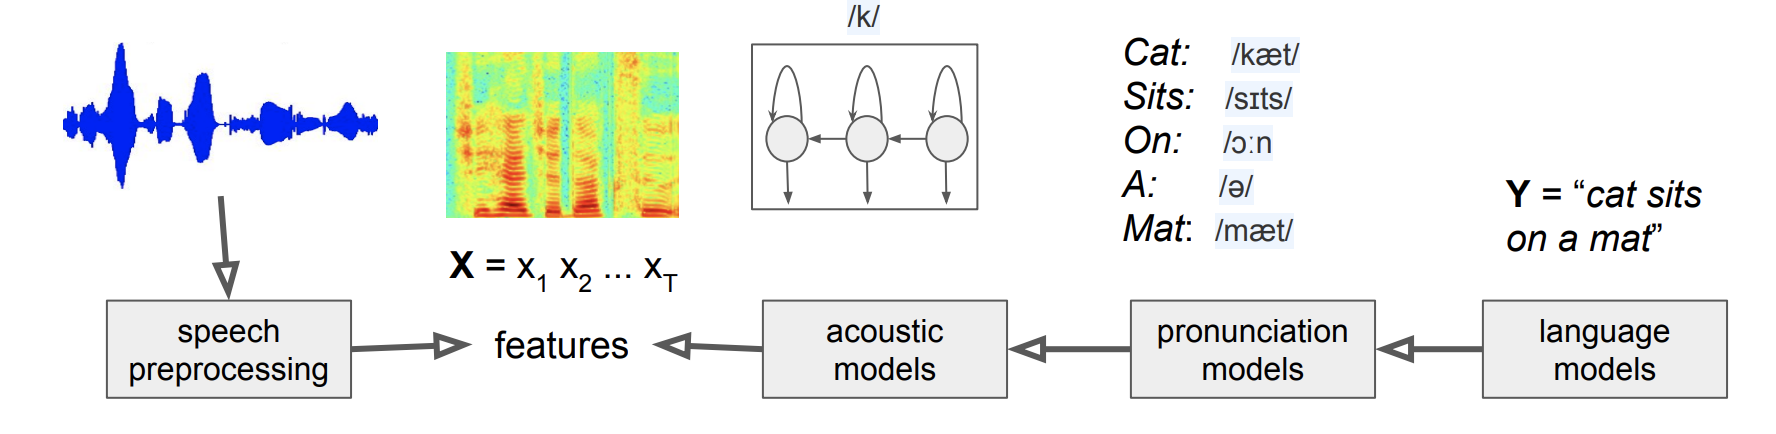

[Source](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1174/lectures/cs224n-2017-lecture12.pdf)

As Deep Learning became more prevelant these traditional models were replaced by their neural equivelants. For example naive ngram models became RNNs and pronunciation lookup table were replaced with neural pronunciation model, and so on. While this improved results, each of these neural models need to be trained independently on on their respective tasks, any mistakes they made had cascading impact on the end models performance. 

These pipeline approaches relied on **temporally-aligned data**, in which each segment of time in an audio file was manually anntoated to align to the phonemes or word in a given segment repeating letters across segments are collapsed in order . 

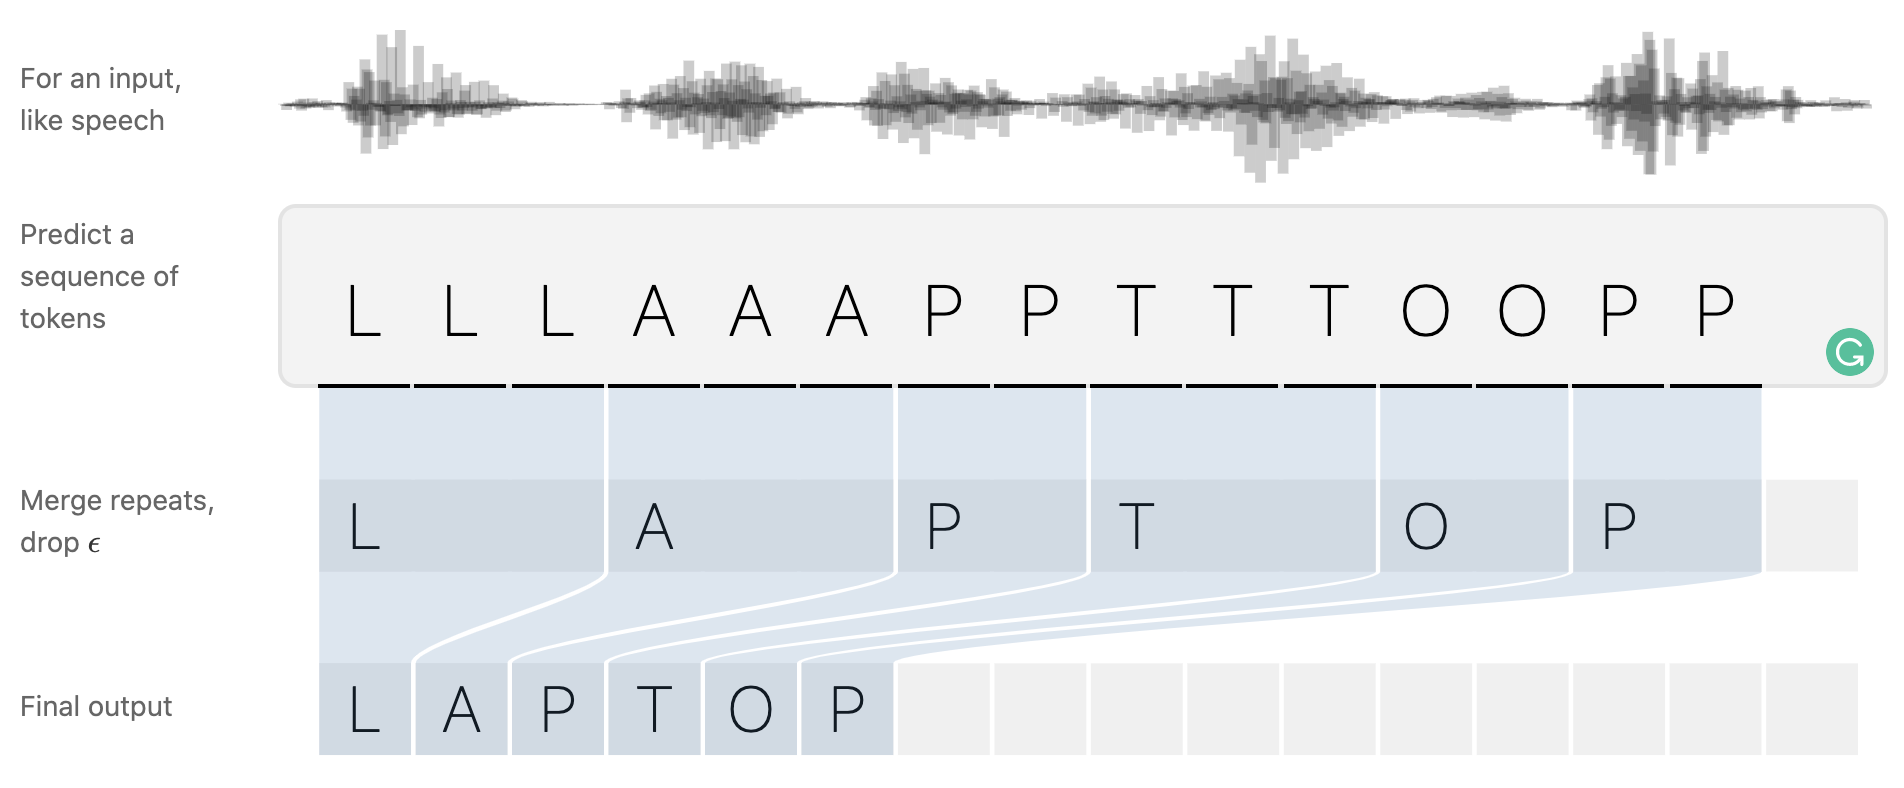

Not not only is **temporally-aligned data** labor-intensive and error prone, it also struggles to properly represent words containing consecutivley repeated letters such as the "book" or "look" as some letter sounds may be duplicated across timesteps.

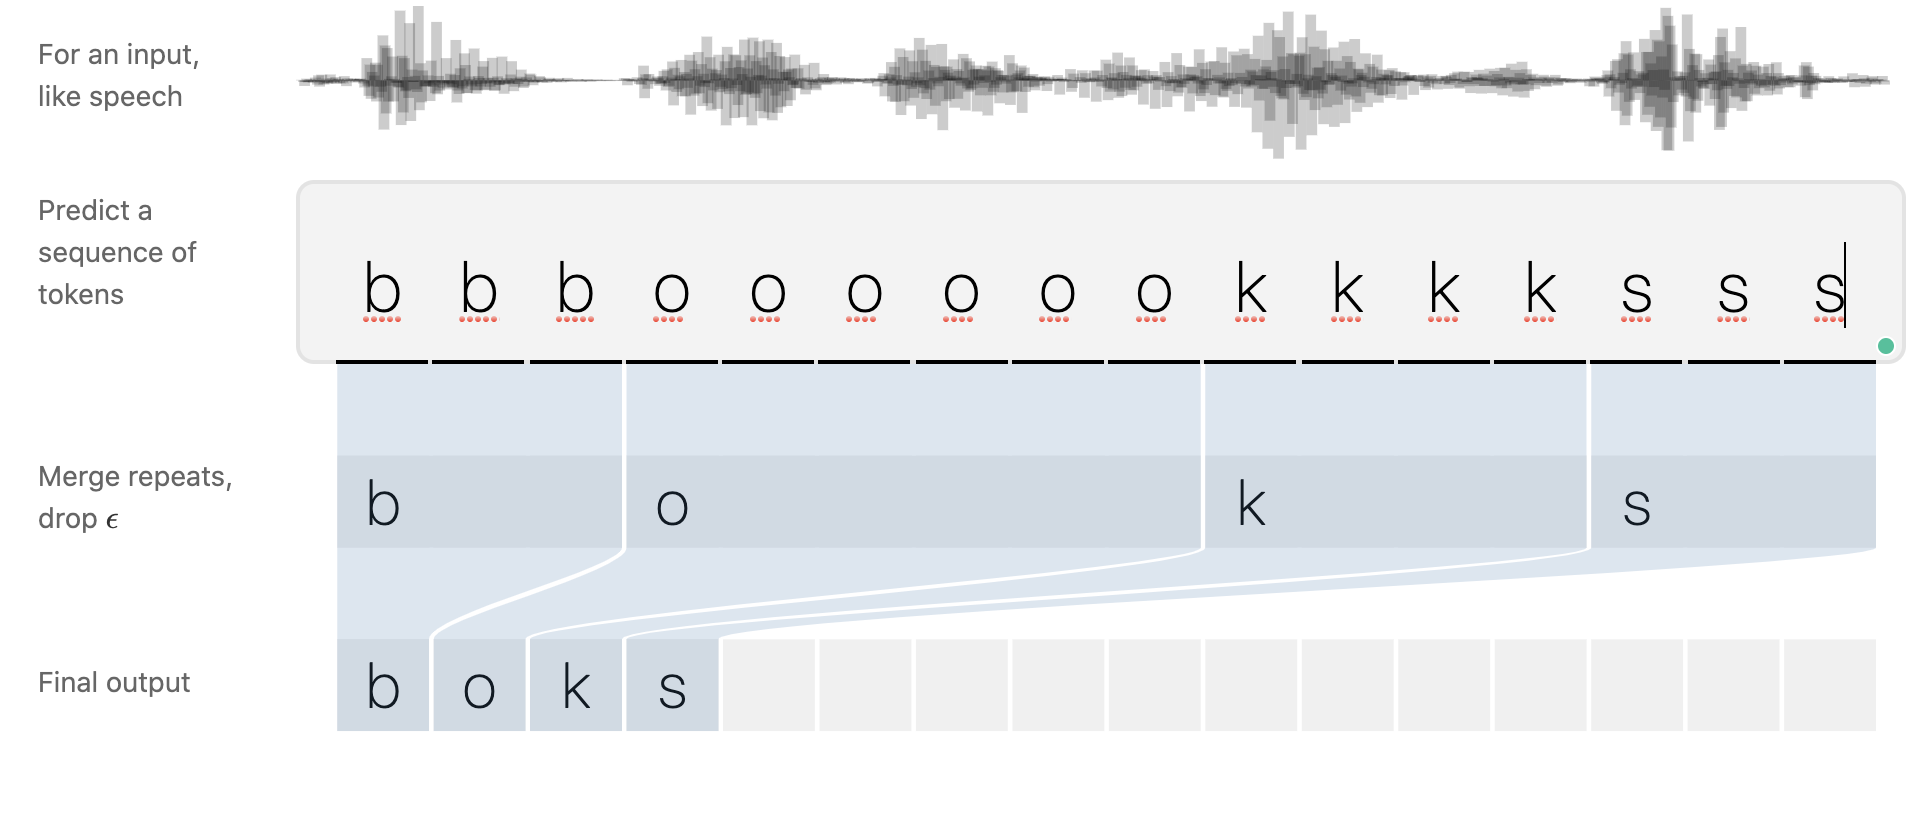
Image generated from (https://distill.pub/2017/ctc/)

### End-to-end ASR architectures to the rescue

Popularized by Alex Graves modern **end-to-end ASR architectures** get around the constraints of **temporally-aligned data** and cascading generative errors using descriminative modeling methods that don't require manual alignment at all. In end-to-end descriminative modeling, models map directly from raw audio and to text transcripts with out requiring any addtional annotation.  Let's briefly go over two popular approaches that allow us to do this, Connectionist Temporal Classification (CTC) and Sequence-to-Sequence models with attention.


#### Connectionist Temporal Classification (CTC)




In normal speech recognition prediction output, we would expect to have characters such as the letters from A through Z, numbers 0 through 9, spaces ("\_"), and so on. CTC introduces a new intermediate output token called the **blank token** ("ϵ") that is useful for getting around the alignment issue.

With CTC, we still predict one token per time segment of speech, but we use the blank token to figure out where we can and can't collapse the predictions. The appearance of a blank token helps separate repeating letters that should not be collapsed. For instance, with an audio snippet segmented into `T=11` time steps, we could get predictions that look like `BOOϵOOOϵϵKK`, which would then collapse to `"BOϵOϵK"`, and then we would remove the blank tokens to get our final output, `BOOK`.

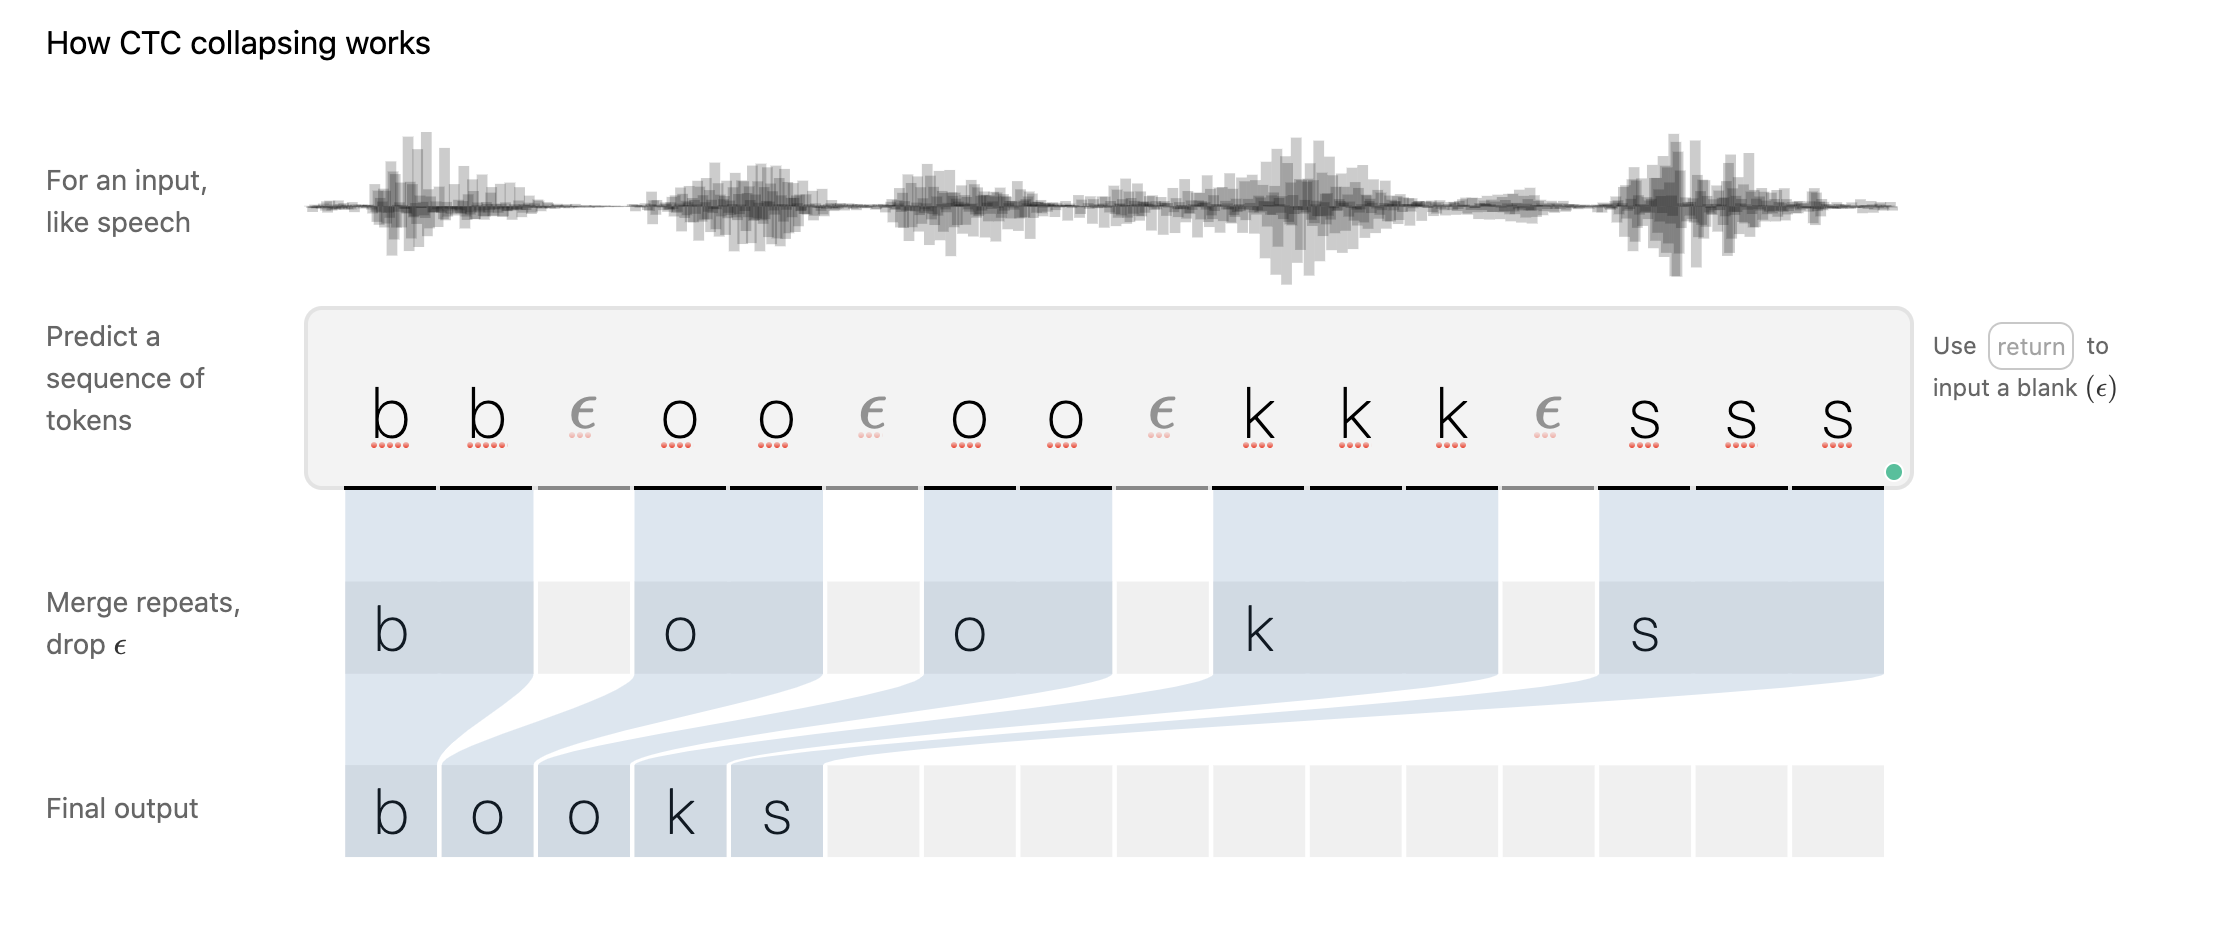

Now, we can predict one output token per time step, then collapse and clean to get sensible output without any fear of ambiguity from repeating letters! A simple way of getting predictions like this would be to apply a bidirectional RNN to the audio input, apply softmax over each time step's output, and then take the token with the highest probability. The method of always taking the best token at each time step is called **greedy decoding, or max decoding**.

If you would like a more in-depth explanation of how CTC works, or how we can improve our results by using a modified beam search algorithm, feel free to check out the Further Reading section at the end of this notebook for more resources.

#### Sequence-to-Sequence with Attention

One problem with CTC is that predictions at different time steps are conditionally independent, which is an issue because the words in a continuous utterance tend to be related to each other in some sensible way. With this conditional independence assumption, we can't learn a language model that can represent such dependencies, though we can add a language model on top of the CTC output to mitigate this to some degree.

A popular alternative is to use a sequence-to-sequence model with attention. A typical seq2seq model for ASR consists of some sort of **bidirectional RNN encoder** that consumes the audio sequence timestep-by-timestep, and where the outputs are then passed to an **attention-based decoder**. Each prediction from the decoder is based on attending to some parts of the entire encoded input, as well as the previously outputted tokens.

The outputs of the decoder can be anything from word pieces to phonemes to letters, and since predictions are not directly tied to time steps of the input, we can just continue producing tokens one-by-one until an end token is given (or we reach a specified max output length). This way, we do not need to deal with audio alignment, and our predicted transcript is just the sequence of outputs given by our decoder.

Now that we have an idea of what some popular end-to-end ASR models look like, let's take a look at the audio data we'll be working with for our example.

## Step 2: Taking a Look at Our Data (AN4)

The AN4 dataset, also known as the Alphanumeric dataset, was collected and published by Carnegie Mellon University. It consists of recordings of people spelling out addresses, names, telephone numbers, etc., one letter or number at a time, as well as their corresponding transcripts. We choose to use AN4 for this tutorial because it is relatively small, with 948 training and 130 test utterances, and so it trains quickly. 

Let's load and take a look at the data. As an example, file `cen2-mgah-b.wav` is a 2.6 second-long audio recording of a man saying the letters "G L E N N" one-by-one. To confirm this, we can listen to the file:

In [3]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

In an ASR task, if this WAV file was our input, then "G L E N N" would be our desired output.

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers:

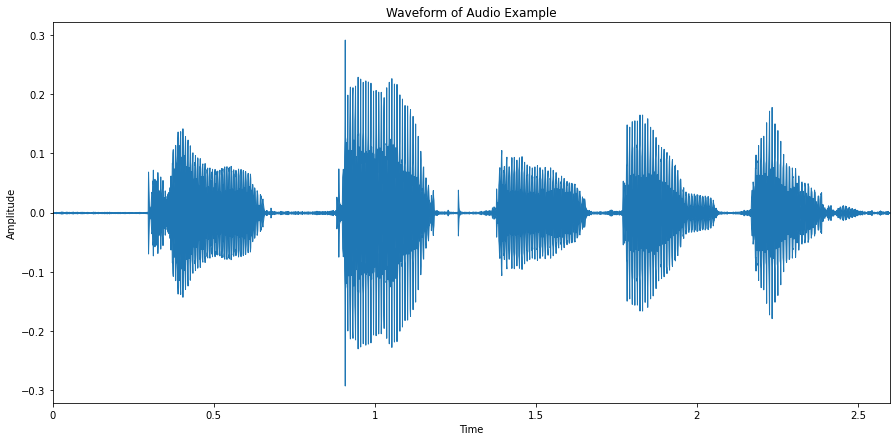

In [4]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

We can see the activity in the waveform that corresponds to each letter in the audio, as our speaker here enunciates quite clearly!
You can kind of tell that each spoken letter has a different "shape," and it's interesting to note that last two blobs look relatively similar, which is expected because they are both the letter "N."

### Spectrograms and Mel Spectrograms

However, since audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values.
We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file.
A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

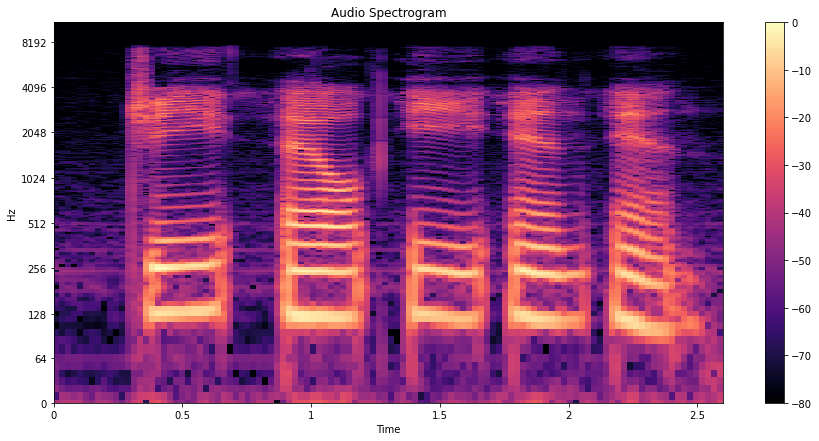

In [5]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

Again, we see each letter being pronounced, and that the last two blobs that correspond to the "N"s are pretty similar-looking. But how do we interpret these shapes and colors? Just as in the waveform plot before, we see time passing on the x-axis (all 2.6s of audio). But now, the y-axis represents different frequencies (on a log scale), and *the color on the plot shows the strength of a frequency at a particular point in time*.

We're still not done yet, as we can make one more potentially useful tweak: using the **Mel Spectrogram** instead of the normal spectrogram. This is simply a change in the frequency scale that we use from linear (or logarithmic) to the mel scale, which is "a perceptual scale of pitches judged by listeners to be equal in distance from one another" (from [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale)).

In other words, it's a transformation of the frequencies to be more aligned to what humans perceive; a change of +1000Hz from 2000Hz->3000Hz sounds like a larger difference to us than 9000Hz->10000Hz does, so the mel scale normalizes this such that equal distances sound like equal differences to the human ear. Intuitively, we use the mel spectrogram because in this case we are processing and transcribing human speech, such that transforming the scale to better match what we hear is a useful procedure.

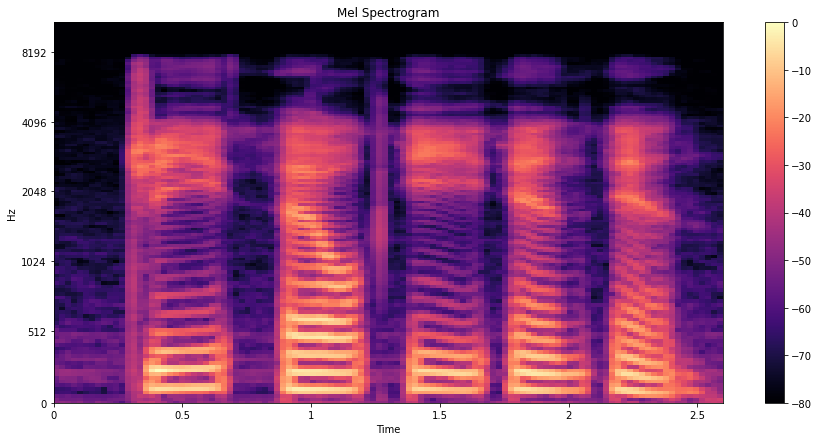

In [6]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

### Creating Data Manifests

To use NeMo we need to to create manifests for our training and evaluation data, which will contain the metadata of our audio files. NeMo data sets take in a standardized manifest format where each line corresponds to one sample of audio, such that the number of lines in a manifest is equal to the number of samples that are represented by that manifest. A line must contain the path to an audio file, the corresponding transcript (or path to a transcript file), and the duration of the audio sample.

Here's an example of what one line in a NeMo-compatible manifest might look like:
```
{"audio_filepath": "path/to/audio.wav", "duration": 3.45, "text": "this is a nemo tutorial"}
```

We can build our training and evaluation manifests using `an4/etc/an4_train.transcription` and `an4/etc/an4_test.transcription`, which have lines containing transcripts and their corresponding audio file IDs:
```
...
<s> P I T T S B U R G H </s> (cen5-fash-b)
<s> TWO SIX EIGHT FOUR FOUR ONE EIGHT </s> (cen7-fash-b)
...
```

In [7]:
# --- Building Manifest Files --- #
import json

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')
                
# Building Manifests
print("******")
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
if not os.path.isfile(train_manifest):
    build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
    print("Training manifest created.")

test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
if not os.path.isfile(test_manifest):
    build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
    print("Test manifest created.")
print("***Done***")

******
Training manifest created.
Test manifest created.
***Done***


## Step 3: Loading Convolutional ASR Models from NGC with NeMo

Now that we have processed our data let's take a look at the model that we will be building, and how we specify its parameters.

### The Jasper Model

We will be training a small [Jasper (Just Another SPeech Recognizer) model/ QuartzNet](https://arxiv.org/abs/1904.03288) from scratch (e.g. initialized randomly). 
In brief, Jasper architectures consist of a repeated block structure that utilizes 1D convolutions.
In a Jasper_KxR model, `R` sub-blocks (consisting of a 1D convolution, batch norm, ReLU, and dropout) are grouped into a single block, which is then repeated `K` times.
We also have a one extra block at the beginning and a few more at the end that are invariant of `K` and `R`, and we use CTC loss. QuartzNet is better variant of Jasper with a key difference that it uses time-channel separable 1D convolutions. This allows it to dramatically reduce number of weights while keeping similar accuracy.

A Jasper/QuartzNet models look like this (QuartzNet model is pictured):

![QuartzNet with CTC](https://developer.nvidia.com/blog/wp-content/uploads/2020/05/quartznet-model-architecture-1-625x742.png)

Now that we have an idea of what ASR is and what the audio data looks like, we can start using NeMo to do some ASR!

NeMo lets us easily hook together the components (modules) of our model, such as the data layer, intermediate layers, and various losses, without worrying too much about implementation details of individual parts or connections between modules. NeMo also comes with complete models which only require your data and hyperparameters for training.

In [8]:
# NeMo's "core" package
import nemo
import nemo.collections.asr as nemo_asr

[NeMo W 2021-08-19 14:04:36 optimizers:47] Apex was not found. Using the lamb optimizer will error out.
2021-08-19 14:04:36.973220: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2021-08-19 14:04:39 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text_dali._AudioTextDALIDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.


## Using an Out-of-the-Box NGC Model

As mentioned earlier NVIDIA NGC catalog is the hub for GPU-optimized software including AI/ML containers, pre-trained models, and SDKs that can be easily deployed across on-premises, cloud, edge, and hybrid environments. NGC offers Transfer Learning Toolkit that enables retraining models on custom data and Triton Inference Server to run predictions on CPU and GPU-powered systems. We will use the native integration between NeMo and NGC to load our Quartznet model.


In [9]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2021-08-19 14:04:45 cloud:56] Found existing object /home/jovyan/.cache/torch/NeMo/NeMo_1.2.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2021-08-19 14:04:45 cloud:62] Re-using file from: /home/jovyan/.cache/torch/NeMo/NeMo_1.2.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2021-08-19 14:04:45 common:681] Instantiating model from pre-trained checkpoint
[NeMo I 2021-08-19 14:04:46 features:252] PADDING: 16
[NeMo I 2021-08-19 14:04:46 features:269] STFT using torch
[NeMo I 2021-08-19 14:04:53 save_restore_connector:143] Model EncDecCTCModel was successfully restored from /home/jovyan/.cache/torch/NeMo/NeMo_1.2.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Next, we'll simply add paths to files we want to transcribe into the list and pass it to our model. Note that it will work for relatively short (<25 seconds) files. 

In [10]:
files = ['./an4/wav/an4_clstk/mgah/cen2-mgah-b.wav']
for fname, transcription in zip(files, quartznet.transcribe(paths2audio_files=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")

[NeMo W 2021-08-19 14:04:54 patch_utils:49] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-08-19 14:04:54 nemo_logging:349] /home/jovyan/conda/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
    To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
      return torch.floor_divide(self, other)
    



Audio in ./an4/wav/an4_clstk/mgah/cen2-mgah-b.wav was recognized as: g l e n n


That was easy! But there are plenty of scenarios where you would want to fine-tune the model on your own data or even train from scratch. For example, this out-of-the box model will obviously not work for Spanish and would likely perform poorly for telephone audio. So if you have collected your own data, you certainly should attempt to fine-tune or train on it!

## Step 4: Training our QuartzNet Model from Scratch using Nemo and PyTorch Lightning

To train from scratch, you need to prepare your training data in the right format and specify your models architecture.

### Specifying Our Model with a YAML Config File

For this tutorial, we'll build a *Jasper_4x1 model*, with `K=4` blocks of single (`R=1`) sub-blocks and a *greedy CTC decoder*, using the configuration found in `./configs/config.yaml`.

If we open up this config file, we find model section which describes architecture of our model. A model contains an entry labeled `encoder`, with a field called `jasper` that contains a list with multiple entries. Each of the members in this list specifies one block in our model, and looks something like this:
```
- filters: 128
  repeat: 1
  kernel: [11]
  stride: [2]
  dilation: [1]
  dropout: 0.2
  residual: false
  separable: true
  se: true
  se_context_size: -1
```
The first member of the list corresponds to the first block in the Jasper architecture diagram, which appears regardless of `K` and `R`.
Next, we have four entries that correspond to the `K=4` blocks, and each has `repeat: 1` since we are using `R=1`.
These are followed by two more entries for the blocks that appear at the end of our Jasper model before the CTC loss.

There are also some entries at the top of the file that specify how we will handle training (`train_ds`) and validation (`validation_ds`) data.

Using a YAML config such as this is helpful for getting a quick and human-readable overview of what your architecture looks like, and allows you to swap out model and run configurations easily without needing to change your code.

In [11]:
# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/config.yaml'

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'tarred_shard_strategy': 'scatter'}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False}, 'preprocessor': {'_target_': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor', 'normal

### Training with PyTorch Lightning

NeMo models and modules can be used in any PyTorch code where torch.nn.Module is expected.

However, NeMo's models are based on [PytorchLightning's](https://github.com/PyTorchLightning/pytorch-lightning) LightningModule and we recommend you use PytorchLightning for training and fine-tuning as it makes using mixed precision and distributed training very easy. For more reasons on why to use Lightning check out the following [post](https://devblog.pytorchlightning.ai/why-should-i-use-pytorch-lightning-488760847b8b)] from the Lightning DevBlog.

To start, let's create Trainer instance for training on GPU for 50 epochs

In [15]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs


Next, we instantiate and ASR model based on our ``config.yaml`` file from the previous section.
Note that this is a stage during which we also tell the model where our training and validation manifests are.

In [13]:
from omegaconf import DictConfig
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
first_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

[NeMo I 2021-08-19 14:05:45 audio_to_text_dataset:36] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2021-08-19 14:05:45 audio_to_text_dataset:36] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2021-08-19 14:05:45 collections:173] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2021-08-19 14:05:45 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-08-19 14:05:45 audio_to_text_dataset:36] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2021-08-19 14:05:45 audio_to_text_dataset:36] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2021-08-19 14:05:45 collections:173] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2021-08-19 14:05:45 collections:174] 0 files were filtered total

With that, we can start training with just one line!

In [14]:
# Start training!!!
trainer.fit(first_asr_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2021-08-19 14:05:52 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2021-08-19 14:05:52 lr_scheduler:621] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fb2dc1251f0>" 
    will be used during training (effective maximum steps = 300) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 300
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.836     Total estimated model params size (MB)

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder        

[NeMo W 2021-08-19 14:05:52 nemo_logging:349] /home/jovyan/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2021-08-19 14:05:52 nemo_logging:349] /home/jovyan/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2021-08-19 14:05:52 nemo_logging:349] /home/jovyan/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:32

There we go! We've put together a full training pipeline for the model and trained it for 50 epochs.

If you'd like to save this model checkpoint for loading later (e.g. for fine-tuning, or for continuing training), you can simply call `first_asr_model.save_to(<checkpoint_path>)`. Then, to restore your weights, you can rebuild the model using the config (let's say you call it `first_asr_model_continued` this time) and call `first_asr_model_continued.restore_from(<checkpoint_path>)`.

### After Training: Monitoring Progress and Changing Hyperparameters
We can  now start Tensorboard to see how training went. Recall that WER stands for Word Error Rate and so the lower it is, the better.

In [16]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

We could improve this model by playing with hyperparameters. We can look at the current hyperparameters with the following:

In [17]:
print(params['model']['optim'])

{'name': 'novograd', 'lr': 0.01, 'betas': [0.8, 0.5], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'monitor': 'val_loss', 'reduce_on_plateau': False, 'warmup_steps': None, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}


Let's say we wanted to change the learning rate. To do so, we can create a `new_opt` dict and set our desired learning rate, then call `<model>.setup_optimization()` with the new optimization parameters.

In [23]:
import copy
new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001
first_asr_model.setup_optimization(optim_config=DictConfig(new_opt))
# And then you can invoke trainer.fit(first_asr_model)

[NeMo I 2021-08-09 07:19:50 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2021-08-09 07:19:50 lr_scheduler:621] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f828683c2b0>" 
    will be used during training (effective maximum steps = 300) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 300
    )


(Novograd (
 Parameter Group 0
     amsgrad: False
     betas: [0.8, 0.5]
     eps: 1e-08
     grad_averaging: False
     initial_lr: 0.001
     lr: 0.001
     weight_decay: 0.001
 ),
 {'scheduler': <nemo.core.optim.lr_scheduler.CosineAnnealing at 0x7f828683c2b0>,
  'interval': 'step',
  'frequency': 1,
  'monitor': 'val_loss',
  'reduce_on_plateau': False})

## Model Improvements

You already have all you need to create your own ASR model in NeMo, but there are a few more tricks that you can employ if you so desire. In this section, we'll briefly cover a few possibilities for improving an ASR model.

### Data Augmentation

There exist several ASR data augmentation methods that can increase the size of our training set.

For example, we can perform augmentation on the spectrograms by zeroing out specific frequency segments ("frequency masking") or time segments ("time masking") as described by [SpecAugment](https://arxiv.org/abs/1904.08779), or zero out rectangles on the spectrogram as in [Cutout](https://arxiv.org/pdf/1708.04552.pdf). In NeMo, we can do all three of these by simply adding in a `SpectrogramAugmentation` neural module. (As of now, it does not perform the time warping from the SpecAugment paper.)

Our toy model does not do spectrogram augmentation. But the real one we got from cloud does:

In [32]:
print(quartznet._cfg['spec_augment'])

{'_target_': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}


If you want to enable SpecAugment in your model, make sure your .yaml config file contains 'model/spec_augment' section which looks like the one above.

### Transfer learning

Transfer learning is an important machine learning technique that uses a model’s knowledge of one task to make it perform better on another. Fine-tuning is one of the techniques to perform transfer learning. It is an essential part of the recipe for many state-of-the-art results where a base model is first pretrained on a task with abundant training data and then fine-tuned on different tasks of interest where the training data is less abundant or even scarce.

In ASR you might want to do fine-tuning in multiple scenarios, for example, when you want to improve your model's performance on a particular domain (medical, financial, etc.) or on accented speech. You can even transfer learn from one language to another! Check out [this paper](https://arxiv.org/abs/2005.04290) for examples.

Transfer learning with NeMo is simple. Let's demonstrate how the model we got from the cloud could be fine-tuned on AN4 data. (NOTE: this is a toy example). And, while we are at it, we will change model's vocabulary, just to demonstrate how it's done.

In [33]:
# Check what kind of vocabulary/alphabet the model has right now
print(quartznet.decoder.vocabulary)

# Let's add "!" symbol there. Note that you can (and should!) change the vocabulary
# entirely when fine-tuning using a different language.
quartznet.change_vocabulary(
    new_vocabulary=[
        ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
        'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", "!"
    ]
)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]
[NeMo I 2021-08-09 07:22:36 ctc_models:339] Changed decoder to output to [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '!'] vocabulary.


After this, our decoder has completely changed, but our encoder (which is where most of the weights are) remained intact. Let's fine tune-this model for 2 epochs on AN4 dataset. We will also use the smaller learning rate from ``new_opt` (see the "After Training" section)`.

In [35]:
# Use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=params['model']['validation_ds'])

# And now we can create a PyTorch Lightning trainer and call `fit` again.
trainer = pl.Trainer(gpus=-1, max_epochs=2)
trainer.fit(quartznet)

[NeMo W 2021-08-09 07:23:08 modelPT:436] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-08-09 07:23:08 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2021-08-09 07:23:08 lr_scheduler:604] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2021-08-09 07:23:08 audio_to_text_dataset:36] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2021-08-09 07:23:08 audio_to_text_dataset:36] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2021-08-09 07:23:08 collections:173] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2021-08-09 07:23:08 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-08-09 07:23:08 audio_to_text_dataset:36] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2021-08-09 07:23:08 audio_to_text_dataset:36] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2021-08-09 07:23:08 collections:173] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2021-08-09 07:23:08 collections:174] 0 files were filtered total

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2021-08-09 07:23:08 modelPT:436] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-08-09 07:23:08 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2021-08-09 07:23:08 lr_scheduler:604] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | spec_augmentation | SpectrogramAugmentation           | 0     
3 | _wer              | WER                               | 0     
4 | decoder           | ConvASRDecoder                    | 30.8 K
5 | loss              | CTCLoss                           | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.702    Total estimated model params size (MB)


[NeMo W 2021-08-09 07:23:08 nemo_logging:349] /home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2021-08-09 07:23:09 nemo_logging:349] /home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


### Fast Training

Last but not least, we could simply speed up training our model! If you have the resources, you can speed up training by splitting the workload across multiple GPUs. Otherwise (or in addition), there's always mixed precision training, which allows you to increase your batch size.

You can use [PyTorch Lightning's Trainer object](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=Trainer) to handle mixed-precision and distributed training for you. Below are some examples of flags you would pass to the `Trainer` to use these features:

```python
# Mixed precision:
trainer = pl.Trainer(amp_level='O1', precision=16)

# Trainer with a distributed backend:
trainer = pl.Trainer(gpus=2, num_nodes=2, accelerator='ddp')

# Of course, you can combine these flags as well.
```

Finally, have a look at [example scripts in NeMo repository](https://github.com/NVIDIA/NeMo/blob/stable/examples/asr/speech_to_text.py) which can handle mixed precision and distributed training using command-line arguments.

# Further Reading/Watching:

That's all for now! If you'd like to learn more about the topics covered in this tutorial, here are some resources that may interest you:
- [Stanford Lecture on ASR](https://www.youtube.com/watch?v=3MjIkWxXigM)
- ["An Intuitive Explanation of Connectionist Temporal Classification"](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Explanation of CTC with Prefix Beam Search](https://medium.com/corti-ai/ctc-networks-and-language-models-prefix-beam-search-explained-c11d1ee23306)
- [Listen Attend and Spell Paper (seq2seq ASR model)](https://arxiv.org/abs/1508.01211)
- [Explanation of the mel spectrogram in more depth](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)
- [Jasper Paper](https://arxiv.org/abs/1904.03288)
- [QuartzNet paper](https://arxiv.org/abs/1910.10261)
- [SpecAugment Paper](https://arxiv.org/abs/1904.08779)
- [Explanation and visualization of SpecAugment](https://towardsdatascience.com/state-of-the-art-audio-data-augmentation-with-google-brains-specaugment-and-pytorch-d3d1a3ce291e)
- [Cutout Paper](https://arxiv.org/pdf/1708.04552.pdf)
- [Transfer Learning Blogpost](https://developer.nvidia.com/blog/jump-start-training-for-speech-recognition-models-with-nemo/)